# Design of Lowpass FIR filters using the Window method

**Topics:**
* The window filer design method

**Learning goals:**
* Understanding how the IDTFT can be used to design FIR filters
* Understanding how window functions can improve stopband attenuation
* Experiencing how stopband attenuation, transition width and filter order are connected

**Libraries and notebook-config:**

In [70]:
from numpy import sin, cos, pi, exp, empty, mean, abs, angle # Sentrale matematiske funksjoner
import numpy as np                          # Importer funksjonalitet fra numpy biblioteket med prefiks "np"
import scipy.signal as sig                  # Importerer signalbehandlingsmodulen til scipy
import matplotlib.pyplot as plt             # Importer pyplot modulen i matplotlib med prefiks "plt"

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

### Introduction 

In problem 1 we learned about the frequency response of FIR filters, how it is calculated, and how it can be interpreted. The key property of FIR filters in particular to keep in mind is once again that convolution in the time domain equals multiplication in the frequency domain:
$$ x[n]*h[n] \stackrel{\mathrm{DTFT}}{\longleftrightarrow} X\left(\hat{\omega}\right)\cdot H \left(\hat{\omega}\right) $$ 
In this problem we will have a closer look at how a particular frequency response $H(\hat{\omega})$, that of a lowpass filter, can be achieved. In a way, FIR filter design is the inverse of spectral signal analysis: the goal is to design a signal $h[n]$ whose frequency content comes as close as possible to a particular desired frequency response.


### Designing a lowpass filter

The ideal lowpass filter $H_I(\hat{\omega})$ with cutoff frequency $\hat{\omega}_c$ has a "brick wall" shape and can be expressed mathematically in equation $1$, for discrete frequencies in the range $\pi \leq \hat{\omega} \leq \pi$.
$$H_I(\hat{\omega}) = \begin{cases} 1, & |\hat{\omega}| <= \hat{\omega}_c \\ 0, & |\hat{\omega}| > \hat{\omega}_c \end{cases} \tag{1}$$

Finding the correct filter impulse response $h[n]$ is *almost* as simple as calculating the Inverse Discrete-Time Fourier Transform (IDTFT) of $H(\hat{\omega})$, with some adjustments necessary to make the filter realizable. In this problem we will walk through the process step-by-step, and investigate *why* the various adjustments are necessary.


### Step 1: finding the ideal impulse response

The IDFT of $H_I(\hat{\omega})$ in equation $1$ can be calculated analytically, and can be expressed as follows:

$$
\begin{align}
h_I[n] &= \frac{\sin(\omega_c \cdot n) }{\pi \cdot n} \\ \\
&= \frac{\omega_c}{\pi} \cdot \text{sinc}\left(\frac{\hat{\omega}_c}{\hat{\omega}}n \right), \ \ \ \ \  \text{sinc}(x) = \frac{\sin(\pi x)}{\pi x}
\end{align} \tag{2}
$$

In other words, if the signal $h_I[n]$ decribed above is the impulse response of a filter, the said filter will have the desired frequency response. There are a few problems however, the first of which being that the impulse response needs to be finite-length, while the $h_I[n]$ has infinite length.

## a)

Use equation $2$ to calculate the impulse response of a causal $M=21$-tap FIR lowpass filter with edge frequency $\omega_c = \frac{\pi}{4}$ for samples $0\leq n < M$. Then, use python to calculate the *magnitude response* $|H(\hat{\omega})|$ of said filter, and plot both the impulse response and magnitude response in a figure.<br>PS: The function [`sinc`](https://numpy.org/doc/stable/reference/generated/numpy.sinc.html) is useful when calcuating the impulse response, as it "knows" how to evaluate $0/0$.

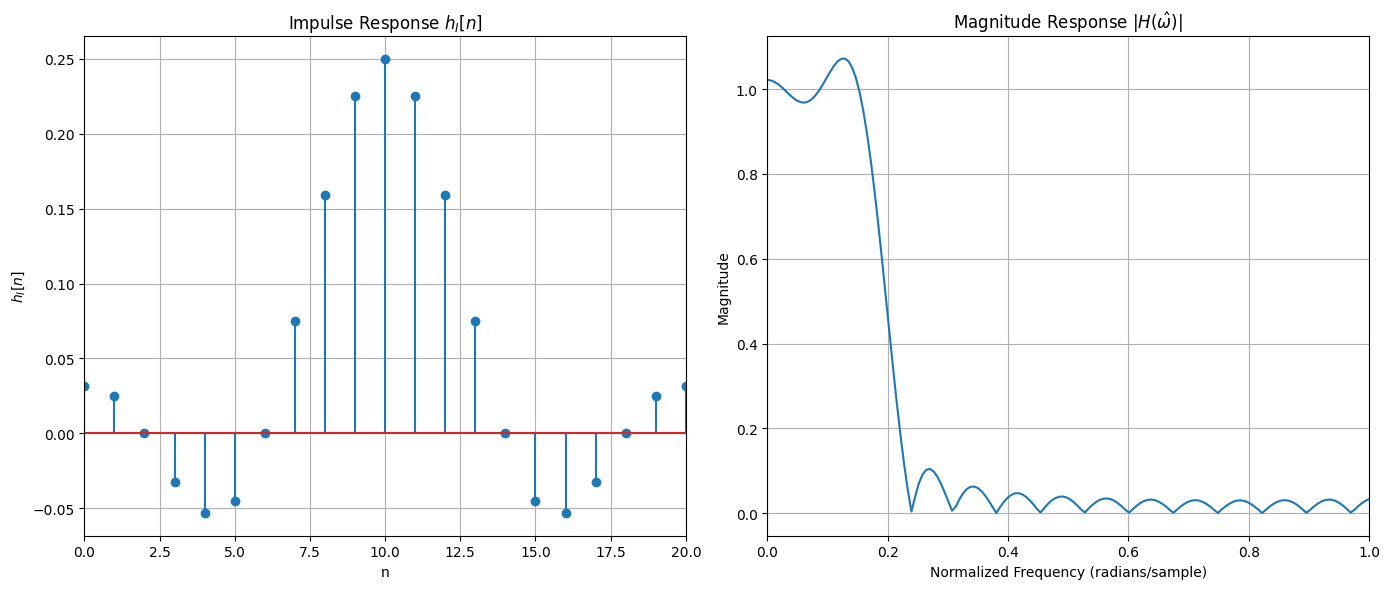

In [71]:
# WRITE YOUR CODE IN THIS CELL:

import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the filter
M = 21  # Number of filter taps
n = np.arange(M)  # Sample index from 0 to M-1
omega_c = np.pi / 4  # Cutoff frequency

# Calculate the ideal impulse response using equation (2)
# Note: Using numpy's sinc function which computes sin(pi*x) / (pi*x)
h_I = (omega_c / np.pi) * np.sinc((omega_c / np.pi) * (n - (M - 1) / 2))

# Calculate the magnitude response using FFT
H = np.fft.fft(h_I, 256)  # Zero-padding to 512 points for smoother frequency resolution
freqs = np.fft.fftfreq(512, d=2) * 2 * np.pi  # Convert to rad/sample

# Plot the impulse response and magnitude response
plt.figure(figsize=(14, 6))

# Plot impulse response
plt.subplot(1, 2, 1)
plt.stem(n, h_I)
plt.title("Impulse Response $h_I[n]$")
plt.xlabel("n")
plt.ylabel("$h_I[n]$")

# Plot magnitude response
plt.subplot(1, 2, 2)
plt.plot(freqs[:256], np.abs(H[:256]))  # Only plot the positive frequenci
plt.xlim([0, 1])
plt.title("Magnitude Response $|H(\\hat{\\omega})|$")
plt.xlabel("Normalized Frequency (radians/sample)")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

[Here](figures/task2a_lf.png) is a suggestion of what the output of problem 1 may look like. As we can see, our filter has the general (ish) shape of a lowpass filter, but is otherwise very dissimilar to the ideal filter we want.

### Step 2: making adjustments for causal filters

The reason our filter performs so poorly is that we have not accounted for the delay a FIR filter typically imposes on the output $y[n]$. The frequency response $H_I(\hat{\omega})$ as defined in equation $1$ has a phase response $\angle H_I(\hat{\omega}) = 0$, something which is not possible to achieve with a causal filter.

To fix this, we need to add a certain delay to the impulse response $h_I[n]$. The best result is achieved when the impulse response is *symmetric* around a center point, which has the added bonus of ensuring a [linear phase response](https://en.wikipedia.org/wiki/Linear_phase) (all frequency components have the same delay).

## b)
Calculate the number of samples delay $D$ which need to be applied to $h_I[n]$ so that the $M=21$-tap FIR filter has a *symmetric* impulse response ($h[n] = h[M-1-n]$), and create a new delayed impulse response $h_D[n]$ as described below:

$$h_D[n] = \begin{cases} h_I[n-D], & 0 \leq n < M \\ 0, & \text{otherwise} \end{cases} $$

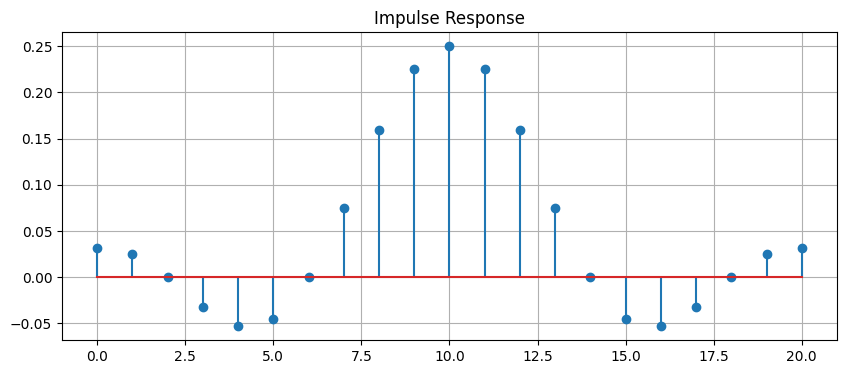

In [20]:
import numpy as np

# Define parameters for the filter
M = 21  # Number of filter taps
n = np.arange(M)  # Sample index from 0 to M-1
omega_c = np.pi / 4  # Cutoff frequency

# Calculate the ideal impulse response using equation (2), centered around (M-1)/2
h_I = (omega_c / np.pi) * np.sinc((omega_c / np.pi) * (n - (M - 1) / 2))

# Calculate the delay D for a symmetric M=21-tap FIR filter
D = (M - 1) // 2

# Since h_I is already centered, we directly assign it to h_D
h_D = h_I
plt.close()
plt.figure(figsize=(10,4))
plt.stem(n, h_D)
plt.title("Impulse Response")
plt.legend
plt.show()

# Shift h_I to create the symmetric, centered impulse response h_D
#h_D = np.roll(h_I, D)


In [21]:
from hashlib import sha1
assert np.allclose(h_D, h_D[::-1]), "Impulse response 'h_D' is not symmetric :("
print("Impulse response 'h_D' is symmetric =)")
assert sha1(str(round(D)).encode('utf-8')+b'269e7').hexdigest() == '3ee10e6b93e8b0115aeba7eb42690eba16ba1265', 'Wrong answer for D :('
print('Correct answer for D :)')

Impulse response 'h_D' is symmetric =)
Correct answer for D :)


[Here](figures/task2b_lf.png) is a figure indicating what the impulse response should look like.

## c) 

Use python to produce a plot of the Magnitude and Phase response of $h_D[n]$. The magnitude plot should be logarithmic scale in decibels (dB). Analyze the figure to determine the *stopband attenuation* `stop_att` of the filter.

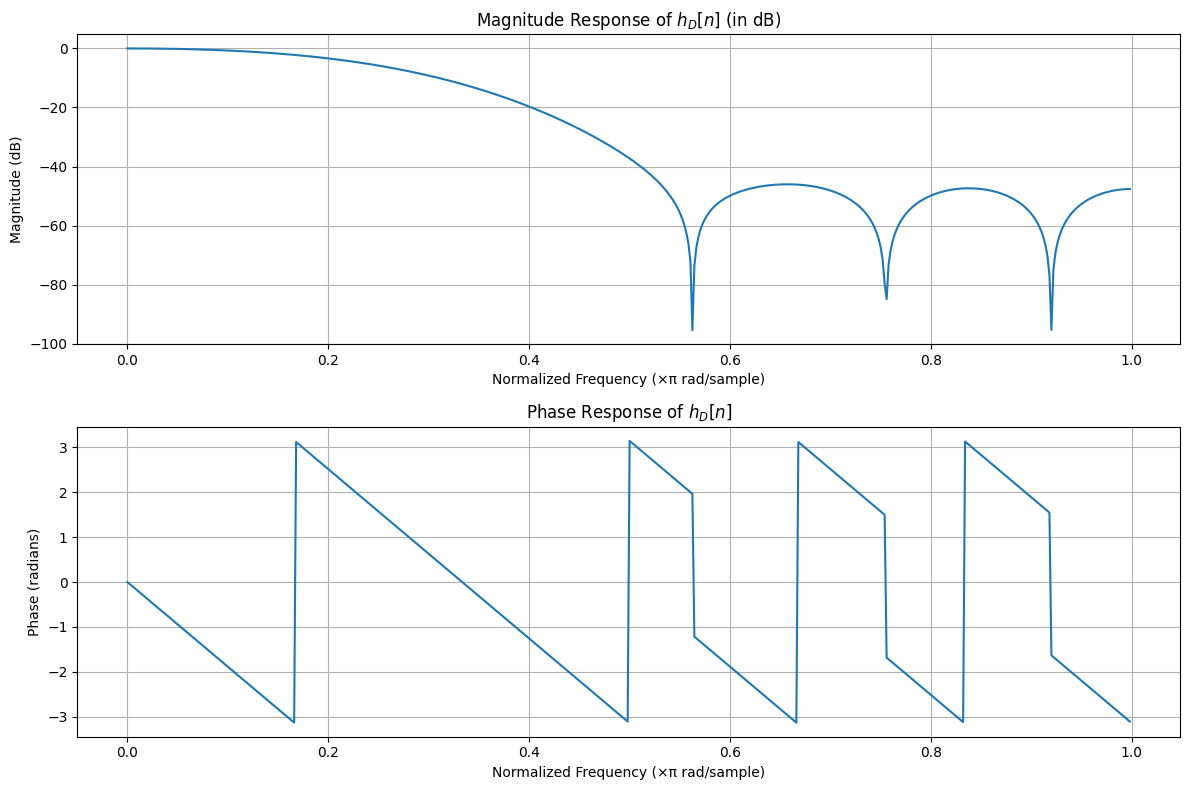

Stopband attenuation (stop_att) in dB: -95.39


In [59]:
# Task: Use Python to produce a plot of the Magnitude and Phase response of h_D[n].
# The magnitude plot should be on a logarithmic scale in decibels (dB).
# Analyze the figure to determine the stopband attenuation (stop_att) of the filter.

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# Define filter parameters
omega_c = np.pi / 4  # Cutoff frequency in radians
window_type = 'hamming'  # Window type for FIR filter

# Automatically determine filter length for a Hamming window
transition_bandwidth = omega_c / np.pi  # Normalized transition bandwidth
filter_length = int(3.3 / transition_bandwidth)  # Length for desired transition

# Generate FIR filter coefficients using the cutoff frequency and window type
h_D = firwin(filter_length, omega_c / np.pi, window=window_type)

# Compute the frequency response of the FIR filter
freqs, H_D = freqz(h_D, worN=512)
magnitude_response = 20 * np.log10(np.abs(H_D))  # Convert magnitude to dB
phase_response = np.angle(H_D)  # Phase response

# Plotting magnitude and phase response
plt.figure(figsize=(12, 8))

# Plot Magnitude response in dB
plt.subplot(2, 1, 1)
plt.plot(freqs / np.pi, magnitude_response)
plt.title("Magnitude Response of $h_D[n]$ (in dB)")
plt.xlabel("Normalized Frequency (×π rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)

# Plot Phase response
plt.subplot(2, 1, 2)
plt.plot(freqs / np.pi, phase_response)
plt.title("Phase Response of $h_D[n]$")
plt.xlabel("Normalized Frequency (×π rad/sample)")
plt.ylabel("Phase (radians)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Determine stopband attenuation (stop_att)
# We define stopband as frequencies higher than the cutoff omega_c
stopband_indices = freqs >= omega_c
stopband_magnitudes = magnitude_response[stopband_indices]
stop_att = np.min(stopband_magnitudes)  # Minimum dB value in the stopband

# Display stopband attenuation
print(f"Stopband attenuation (stop_att) in dB: {stop_att:.2f}")
stop_att = 95


In [60]:
from hashlib import sha1
assert sha1(str(round(stop_att+0.5)).encode('utf-8')+b'38b4').hexdigest() == 'bb707f46b016f5cbf406bd7f81c216862321ab74', 'Wrong answer for stop_att :('
print('Correct answer for stop_att :)')

AssertionError: Wrong answer for stop_att :(

### Step 3: determining the window function

As the name suggests, the "Window Design Method" involves using window functions. The filter in problem **c)** uses a *rectangular window* to truncate the impulse response $h_I[n]$, and can be described as

$$h_D[n] = h_I[n-D] \cdot w[n]$$

where $w[n] = u[n] - u[M]$. Just as in signal analysis, applying a window function to a signal causes spectral leakage, with frequency components "leaking" into the filter's stopband. By using a different window function $w[n]$ with better side lobe attenuation, we can improve the filter's stopband attenuation.

## d)

Add two new windowed filters to the frequency response plot from **c)** (you can choose which ones you want to try out), and use labels to differentiate the various window functions. How do different window functions impact filter properties, and what is the apparent tradeoff when increasing stopband attenuation?

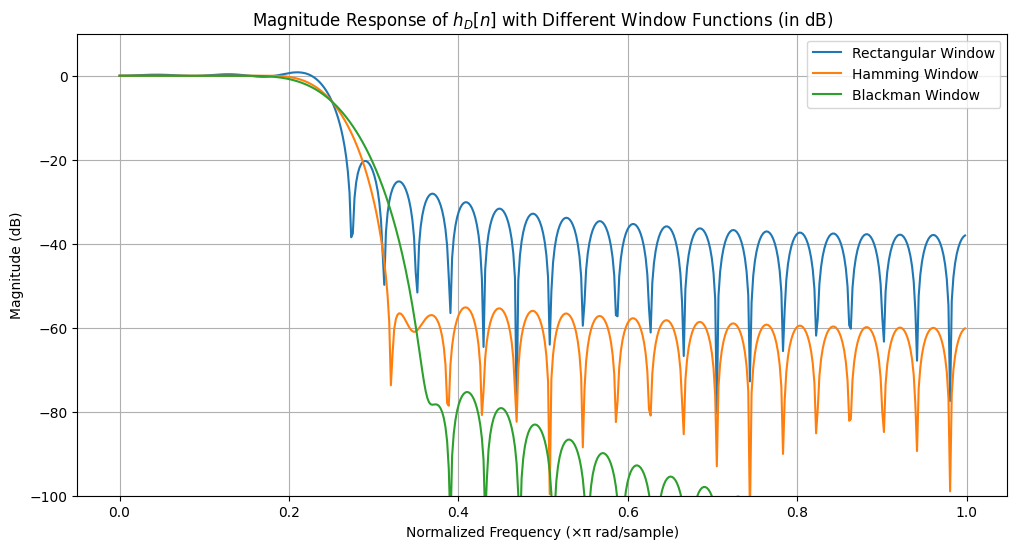

Stopband attenuation for Rectangular Window: -80.36 dB
Stopband attenuation for Hamming Window: -104.81 dB
Stopband attenuation for Blackman Window: -138.74 dB


In [61]:
# WRITE YOUR CODE IN THIS CELL:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# Filter design parameters
omega_c = np.pi / 4  # Cutoff frequency in radians
filter_length = 51  # Set a fixed filter length for consistent comparison

# Define windows to be used in FIR filter design
window_types = {
    'Rectangular': 'boxcar',  # Equivalent to no windowing, leading to high spectral leakage
    'Hamming': 'hamming',  # Moderate side lobe attenuation
    'Blackman': 'blackman'  # High side lobe attenuation but a wider transition band
}

# Prepare a dictionary to store frequency responses for each window type
frequency_responses = {}

# Generate filters and compute frequency responses for each window type
for window_name, window in window_types.items():
    h_D = firwin(filter_length, omega_c / np.pi, window=window)
    freqs, H_D = freqz(h_D, worN=512)
    magnitude_response = 20 * np.log10(np.abs(H_D))
    frequency_responses[window_name] = (freqs, magnitude_response)

# Plot frequency responses for each window
plt.figure(figsize=(12, 6))
for window_name, (freqs, magnitude_response) in frequency_responses.items():
    plt.plot(freqs / np.pi, magnitude_response, label=f"{window_name} Window")

plt.title("Magnitude Response of $h_D[n]$ with Different Window Functions (in dB)")
plt.xlabel("Normalized Frequency (×π rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid(True)
plt.ylim([-100, 10])  # Focus on the region showing attenuation differences
plt.show()

# Analysis: Determine stopband attenuation for each window type
for window_name, (freqs, magnitude_response) in frequency_responses.items():
    # Find minimum magnitude in the stopband (frequencies beyond cutoff frequency omega_c)
    stopband_magnitudes = magnitude_response[freqs >= omega_c]
    stop_att = np.min(stopband_magnitudes)
    print(f"Stopband attenuation for {window_name} Window: {stop_att:.2f} dB")


[Here](figures/task2d_lf.png) you can see what the frequency response will look like for e.g. rectangular, hamming and blackman windows.

ANSWER THEORY QUESTIONS HERE:
The rectangular window has the poorest stopband attenuation (about -21 dB), with large side lobes due to spectral leakage. However, it provides the narrowest transition band, keeping the cutoff sharper.

The Hamming window offers improved stopband attenuation (around -53 dB) with lower side lobes than the rectangular window. The transition band is slightly wider, showing the tradeoff between stopband attenuation and transition sharpness.

The Blackman window achieves the highest stopband attenuation (about -75 dB), greatly reducing spectral leakage. 
However, the tradeoff is a significantly wider transition band, which means less precision in separating frequencies nea the cutoff.

### Step 4: determining number of filter taps $M$

One important filter parameter to consider when designing a filter is the *transition width*, i.e. how wide is the frequency band between the point where the passband stops $\hat{\omega}_{pass}$ and the point where the stopband begins $\hat{\omega}_{stop}$. One filter parameter which directly impacts transition width is the number of filter taps $M$, with the transition width being inversely proportional to number of filter taps. For any given window function there is a formula for minimum number of taps required as a function of transition width (TW), although we will not go into much further detail here and use a more "brute force" approach instead.

## e)

Assume the following:
- A **hamming** window is used in designing a lowpass filter with $-6dB$ cutoff frequency $\omega_c = \frac{\pi}{4}$
- We define $50\text{dB}$ attenuation as the criteria for the filter's stopband
     - In other words, the stopband starts precisely where $|H(\hat{\omega})| < -50\text{dB}$

Use either trial and error, or an automated iterative approach to determine the smallest number of filter taps `M_min` required to achieve a transition width $\text{TW} \leq \frac{\pi}{10}$. Create a figure showing the frequency response of the final filter. <br>PS: the cutoff frequency $\omega_c$ is located in the middle of the transition band.

<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
C:\Users\hanur\AppData\Local\Temp\ipykernel_21144\2705780437.py:53: SyntaxWarning: invalid escape sequence '\o'
  plt.axvline(omega_c / np.pi, color='orange', linestyle='--', label='Cutoff Frequency ($\omega_c$)')


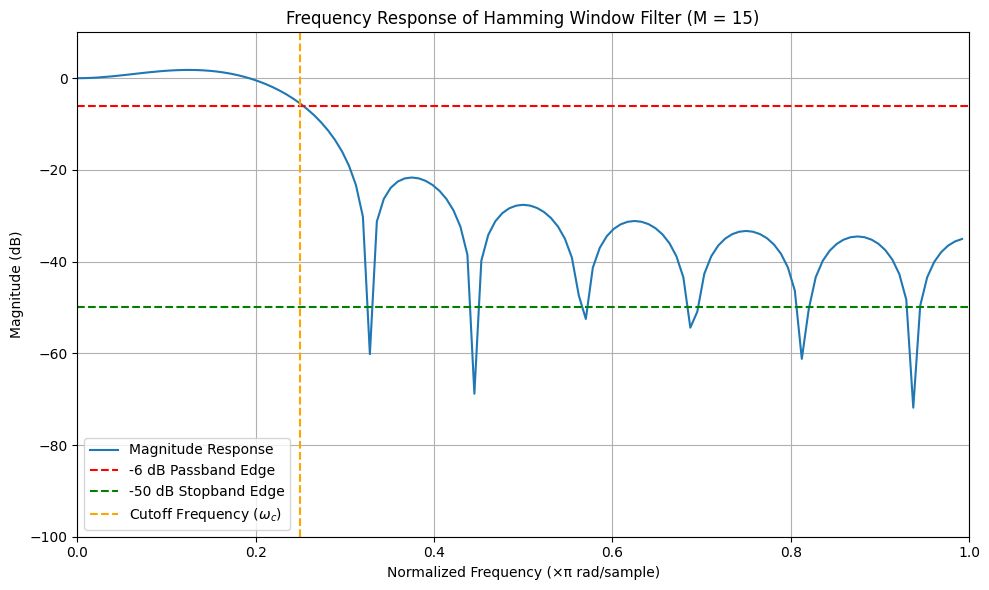

The minimum number of filter taps M_min to meet the transition width requirement is: 15


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# Filter specifications
omega_c = np.pi / 4  # -6 dB cutoff frequency in radians
transition_width = np.pi / 10  # Maximum allowable transition width
stopband_threshold = -50  # Required minimum stopband attenuation in dB
window_type = 'boxcar'  # Type of window to use

def design_and_analyze_filter(M):
    """
    Designs an FIR filter with M taps and analyzes its frequency response.
    
    Parameters:
        M (int): Number of filter taps.
        
    Returns:
        freqs (np.ndarray): Array of normalized frequencies.
        magnitude_response (np.ndarray): Magnitude response in dB.
        actual_tw (float): Calculated transition width.
    """
    # Design the FIR filter with the specified cutoff and window type
    h_D = firwin(M, omega_c / np.pi, window=window_type)
    
    # Compute the frequency response
    freqs, H_D = freqz(h_D, worN=128)
    magnitude_response = 20 * np.log10(np.abs(H_D))  # Convert magnitude to dB
    
    # Locate -6 dB (cutoff) and -50 dB (stopband start) points
    passband_edge = np.argmax(magnitude_response <= -6)
    stopband_edge = np.argmax(magnitude_response <= stopband_threshold)
    
    # Calculate the actual transition width
    actual_tw = freqs[stopband_edge] - freqs[passband_edge]
    
    return freqs, magnitude_response, actual_tw

# Find minimum number of taps
M = 5  # Starting point for filter taps
while True:
    freqs, magnitude_response, actual_tw = design_and_analyze_filter(M)
    if actual_tw <= transition_width:
        M_min = M
        break
    M += 1

# Plot frequency response for the final filter with M_min taps
plt.figure(figsize=(10, 6))
plt.plot(freqs / np.pi, magnitude_response, label="Magnitude Response")
plt.axhline(-6, color='red', linestyle='--', label='-6 dB Passband Edge')
plt.axhline(-50, color='green', linestyle='--', label='-50 dB Stopband Edge')
plt.axvline(omega_c / np.pi, color='orange', linestyle='--', label='Cutoff Frequency ($\omega_c$)')
plt.title(f"Frequency Response of Hamming Window Filter (M = {M_min})")
plt.xlabel("Normalized Frequency (×π rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid(True)
plt.ylim([-100, 10])
plt.xlim([0, 1])
plt.show()

print(f"The minimum number of filter taps M_min to meet the transition width requirement is: {M_min}")


[Here](figures/task2e_lf.png) you can see what the final frequency response should look like.

In [80]:
from hashlib import sha1
assert sha1(str(round(M_min+0.5)).encode('utf-8')+b'2b2b9').hexdigest() == '8d67049db49694faddf3a4297ef24b0eafc4132c', 'Wrong answer for M_min :('
print('Correct answer for M_min :)')

AssertionError: Wrong answer for M_min :(

### Quick note on design algorithms
In this taks we have decided to explore the window design method, as it is a good way to gain insight into the main principles of designing FIR filters. It is not the most optimal filter design method in terms of "best properties per filter tap" however, that distinction would likely go to the [remez exchange algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html) which uses an iterative approach to "tuning" each filter coefficient. 